In [82]:
import autoreload
from ray.tune.analysis import Analysis
import pandas as pd
import multiprocessing
from make_video import make_video, parser
from config import get_config_by_name
import ray
import shutil
from IPython.display import display, FileLink
from matplotlib import pyplot as plt
from analysis_helpers import get_videos, get_scores, concat_videos, VideosDownloader, get_df_from_logdir
import numpy as np
import pickle
import os, json, re
from tqdm import tqdm
import gym_compete_rllib
from ap_rllib.config import get_trainer, get_config_by_name
import seaborn as sns

In [3]:
# need ray for parallel evaluation
ray.shutdown()
ray.init(num_cpus=28, ignore_reinit_error=True, log_to_driver=False)

2020-11-12 17:20:49,760	INFO resource_spec.py:212 -- Starting Ray with 37.35 GiB memory available for workers and up to 18.69 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-11-12 17:20:50,015	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-11-12 17:20:50,262	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '128.32.175.9',
 'raylet_ip_address': '128.32.175.9',
 'redis_address': '128.32.175.9:6379',
 'object_store_address': '/tmp/ray/session_2020-11-12_17-20-49_757888_22587/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-12_17-20-49_757888_22587/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-11-12_17-20-49_757888_22587'}

In [4]:
# loading data
exp_name = "adversarial_tune_eval_sb"
config = "defense_eval_interactive_sb"
analysis = Analysis("/home/sergei/ray_results/" + exp_name)
df = analysis.dataframe(metric='policy_reward_mean/player_1', mode=None)

In [89]:
SCORE_STEPS = 1# 15
VIDEO_STEPS = 1# 15

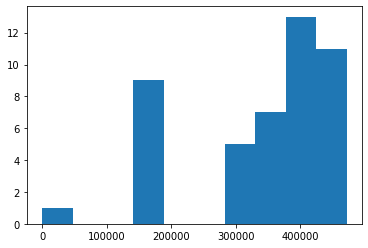

In [90]:
# removing short trials
plt.hist(df['episodes_total'])
df = df[df.episodes_total > 100000]

In [32]:
rdfs = {}
for i, trial in df.iterrows():
    rdfs[trial.trial_id] = get_df_from_logdir(trial.logdir)

100%|██████████| 2622/2622 [00:01<00:00, 1468.64it/s]


Trials ['2cfcb_00008', '2cfcb_00017']


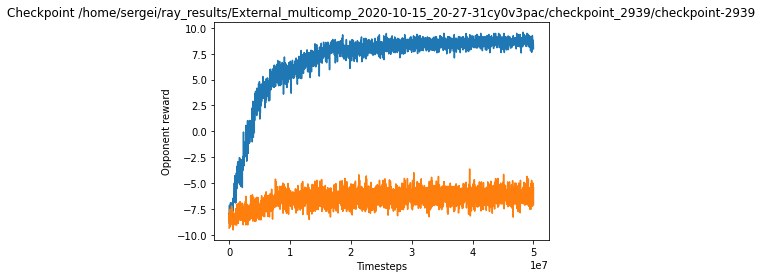

Trials ['2cfcb_00009', '2cfcb_00000']


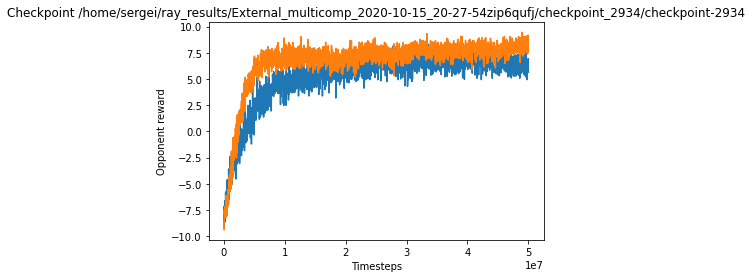

Trials ['2cfcb_00001', '2cfcb_00010']


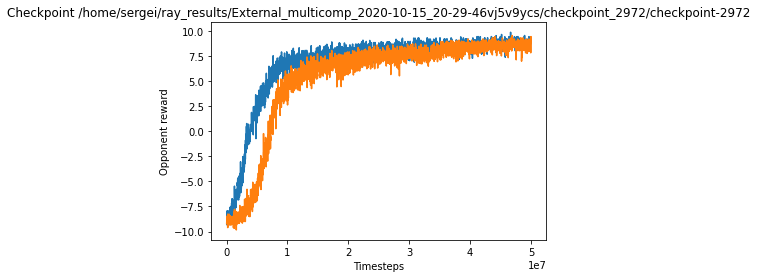

Trials ['2cfcb_00006', '2cfcb_00015']


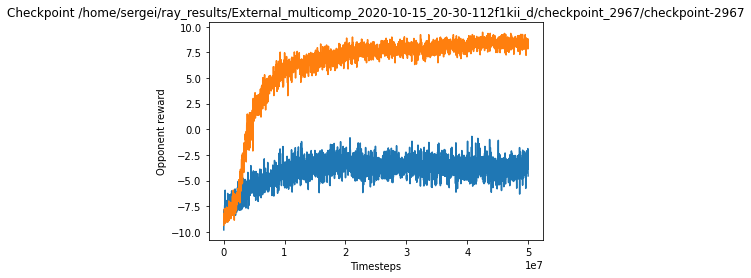

Trials ['2cfcb_00012', '2cfcb_00003']


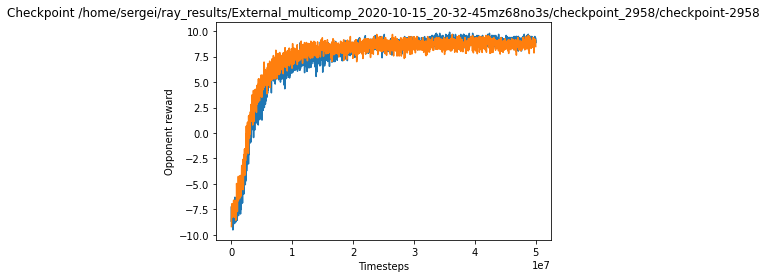

Trials ['2cfcb_00011', '2cfcb_00002']


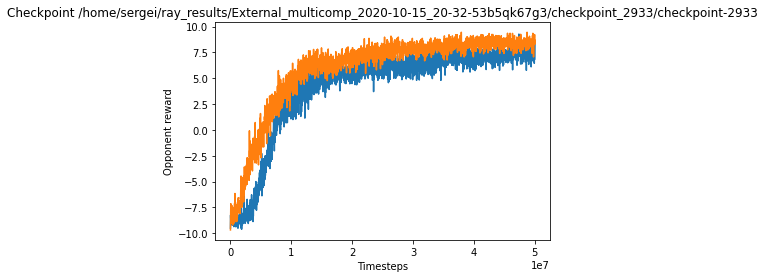

Trials ['2cfcb_00007', '2cfcb_00016']


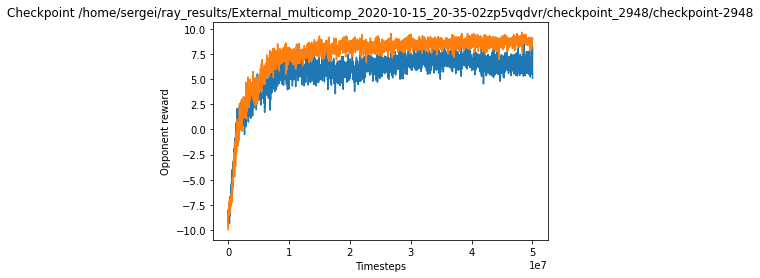

Trials ['2cfcb_00014', '2cfcb_00005']


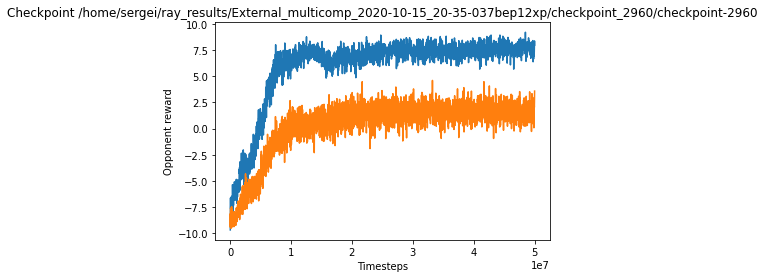

Trials ['2cfcb_00004', '2cfcb_00013']


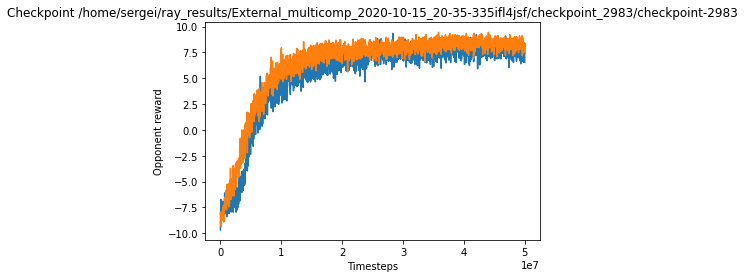

In [133]:
for _, df1 in df.groupby(['config/_checkpoint_restore']):
    plt.title(f"Checkpoint {df1.iloc[0]['config/_checkpoint_restore']}")
    plt.xlabel('Timesteps')
    plt.ylabel('Opponent reward')
    print("Trials", list(df1.trial_id))
    for trial in df1.trial_id:
        rdf = rdfs[trial]
        plt.plot(rdf['timesteps_total'], rdf['policy_reward_mean/player_1'])
    plt.show()

In [139]:
def fill_exponent_from_checkpoint_restore():
    """Add exponents field from the list of checkpoints."""
    exponents = []
    for _, row in df.iterrows():
        ckpt = row['config/_checkpoint_restore']
        params_path = os.path.join(os.path.split(os.path.split(ckpt)[0])[0], 'params.json')
        with open(params_path, 'r') as f:
            ckpt_config = json.loads(f.read())
        exponent = float(re.findall("'_burst_exponent': ([0-9\.]+)", ckpt_config['multiagent']['policy_mapping_fn'])[0])
        exponents.append(exponent)
    df['exponents'] = exponents

In [140]:
fill_exponent_from_checkpoint_restore()

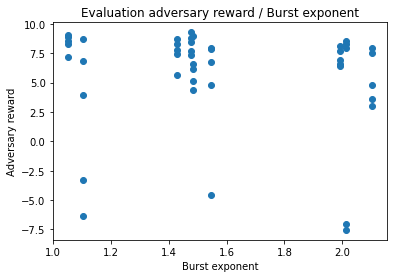

In [141]:
plt.title('Evaluation adversary reward / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary reward')
plt.scatter(df['exponents'], df['policy_reward_mean/player_1'])
plt.show()

In [ ]:
plt.title('Evaluation adversary reward / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary reward')
plt.scatter(df['exponents'], df['policy_reward_mean/player_1'])
plt.show()

In [114]:
config = 'external_test'

In [120]:
SCORE_STEPS = 15
VIDEO_STEPS = 3

In [121]:
scores = get_scores(df, steps=SCORE_STEPS, load_normal=False, config=config)
videos = get_videos(df, steps=VIDEO_STEPS, load_normal=False, config=config)

In [156]:
len(scores)

18

In [129]:
videos

['/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c708bf5e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c706094e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123213-c709004a-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c74f794e-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c75b9d96-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-20201031-123214-c7a3eb28-1baf-11eb-8c5b-e0d55e6af99c/video.000000.mp4',
 '/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/video-2

In [131]:
with VideosDownloader() as vd:

    for i, trial in tqdm(df.iterrows()):
        video = videos[i]
        vd.add_video(video, f"exponent_{round(trial['exponents'], 2)}_trial_{trial.trial_id}.mp4")

18it [00:00, 305.91it/s]


/scratch/sergei/better-adversarial-defenses/ap_rllib_experiment_analysis/videos.zip

In [126]:
df['score_adv'] = [x['wins_policy_player_1_reward'] for x in scores]

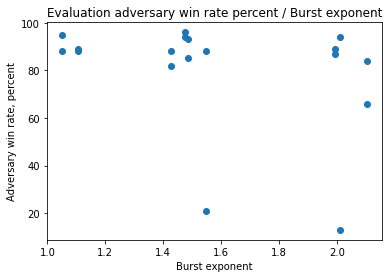

In [128]:
plt.title('Evaluation adversary win rate percent / Burst exponent')
plt.xlabel('Burst exponent')
plt.ylabel('Adversary win rate, percent')
plt.scatter(df['exponents'], df['score_adv'])
plt.show()

### Evaluating all policies against each other

In [96]:
config = 'external_test'
config_ = get_config_by_name(config)
config_['_verbose'] = False
config_['_policies'] = [None, 'pretrained', 'pretrained']
trainer_pretrained = get_trainer(config_)

Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Create

2020-11-12 17:40:52,795	WARNING util.py:37 -- Install gputil for GPU system monitoring.


Setting NN weights
Loading normalization
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [97]:
config = 'external_test'
config_ = get_config_by_name(config)
config_['_verbose'] = False
trainer = get_trainer(config_)

Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Create

2020-11-12 17:40:54,236	WARNING util.py:37 -- Install gputil for GPU system monitoring.


Setting NN weights
Loading normalization
Creating agent humanoid_blocker
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Creating agent humanoid
Reading agent XML from: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/humanoid_body.xml
Scene XML path: /scratch/sergei/better-adversarial-defenses/multiagent-competition/gym_compete/new_envs/assets/world_body.humanoid_body.humanoid_body.xml
Created Scene with agents


In [70]:
policies = trainer.get_weights().keys()

In [91]:
weights = {p: [] for p in policies}

for _, row in df.iterrows():
    ckpt = row.checkpoint_rllib
    trainer.restore(ckpt)
    for p, w in trainer.get_weights().items():
        weights[p].append(w)

2020-11-12 17:35:30,799	INFO trainable.py:423 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-28_07-24-36d572h2g5/checkpoint_2633/checkpoint-2633
2020-11-12 17:35:30,800	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 2633, '_timesteps_total': None, '_time_total': 200047.52867126465, '_episodes_total': 472038}
2020-11-12 17:35:30,810	INFO trainable.py:423 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-30_02-08-11ia0_qn95/checkpoint_2609/checkpoint-2609
2020-11-12 17:35:30,811	INFO trainable.py:430 -- Current state after restoring: {'_iteration': 2609, '_timesteps_total': None, '_time_total': 136909.22732496262, '_episodes_total': 376636}
2020-11-12 17:35:30,820	INFO trainable.py:423 -- Restored on 128.32.175.9 from checkpoint: /home/sergei/ray_results/External_multicomp_2020-10-30_01-59-458ag4aj78/checkpoint_2629/checkpoint-2629
2020-11-12 17:35:30,821	INFO trainabl

In [98]:
for p, w in trainer_pretrained.get_weights().items():
    weights[p].append(w)

In [99]:
def weights_equal(w1, w2):
    """List of weights == another list of weights?"""
    assert len(w1) == len(w2)
    for a, b in zip(w1, w2):
        if not np.allclose(a, b):
            return False
    return True

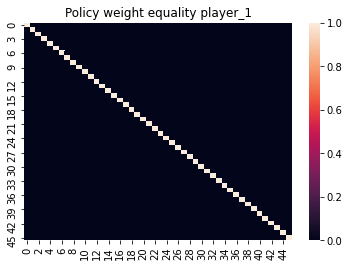

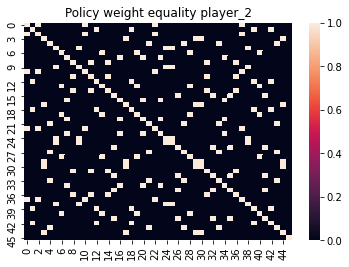

In [100]:
for p in policies:
    plt.title(f"Policy weight equality {p}")
    weq = [[weights_equal(x, y) for x in weights[p]] for y in weights[p]]
    sns.heatmap(weq)
    plt.show()

In [104]:
is_unique = {}
for p in policies:
    is_unique[p] = [not any([weights_equal(x, y) for j, y in enumerate(weights[p]) if j > i]) for i, x in enumerate(weights[p])]

In [106]:
print("Unique policies", {x: sum(y) for x, y in is_unique.items()})

Unique policies {'player_1': 46, 'player_2': 10}


In [114]:
print("Unique checkpoints restored", len(df['config/_checkpoint_restore'].unique()))

Unique checkpoints restored 9


In [130]:
import itertools
from uuid import uuid1

In [128]:
idxes = []

for w_pair in list(itertools.product(*[[(p, x) for x in range(len(w))] for p, w in weights.items()])):
    w_pair = dict(w_pair)
    valid_pair = True
    for p, idx in w_pair.items():
        if not is_unique[p][idx]:
            valid_pair = False
    if not valid_pair:
        continue
    
    idxes.append(w_pair)

In [140]:
for d in tqdm(idxes):
    trainer.set_weights({p: weights[p][d[p]] for p in policies})
    ckpt = trainer.save(f"/tmp/{uuid1()}")
    w_hash = sum([sum([np.sum(t) for t in y]) for y in trainer.get_weights().values()])
    d['checkpoint_rllib'] = ckpt
    d['hash'] = w_hash

100%|██████████| 460/460 [00:02<00:00, 199.87it/s]


In [143]:
hashes = [x['hash'] for x in idxes]

In [146]:
assert len(hashes) == len(set(hashes)), "Some pairs are the same"

In [151]:
fn = "/tmp/to_eval.csv"

In [476]:
df_to_eval = pd.DataFrame(idxes)
df_to_eval.to_csv(fn, index=False)

In [477]:
# run python -m ap_rllib_experiment_analysis.score_video_many --gin_config configs/score_make_video.gin --dataframe /tmp/to_eval.csv --score

In [478]:
with open(fn + "_scores.json", 'r') as f:
    eval_data = json.load(f)
if len(eval_data) < len(df_to_eval):
    print("Warning: not enough data", len(eval_data), len(df_to_eval))

In [479]:
for i, dta in enumerate(eval_data):
    for key, val in dta.items():
        if not key.endswith('reward'): continue
#         print(i, key, val)
        df_to_eval.loc[i, key] = val

In [480]:
df_to_eval

,player_1,player_2,checkpoint_rllib,hash,trials_episode_reward,wins_episode_reward,losses_episode_reward,ties_episode_reward,trials_policy_player_1_reward,wins_policy_player_1_reward,losses_policy_player_1_reward,ties_policy_player_1_reward,trials_policy_player_2_reward,wins_policy_player_2_reward,losses_policy_player_2_reward,ties_policy_player_2_reward
0,0,34,/tmp/a878baaa-2553-11eb-8c5f-e0d55e6af99c/chec...,4381.369831,100.0,12.0,88.0,0.0,100.0,92.0,8.0,0.0,100.0,8.0,92.0,0.0
1,0,36,/tmp/a878baab-2553-11eb-8c5f-e0d55e6af99c/chec...,4367.817321,100.0,10.0,90.0,0.0,100.0,94.0,6.0,0.0,100.0,6.0,94.0,0.0
2,0,37,/tmp/a878baac-2553-11eb-8c5f-e0d55e6af99c/chec...,4382.765925,100.0,16.0,84.0,0.0,100.0,88.0,12.0,0.0,100.0,12.0,88.0,0.0
3,0,38,/tmp/a878baad-2553-11eb-8c5f-e0d55e6af99c/chec...,4389.006600,100.0,11.0,89.0,0.0,100.0,95.0,5.0,0.0,100.0,5.0,95.0,0.0
4,0,40,/tmp/a878baae-2553-11eb-8c5f-e0d55e6af99c/chec...,4358.757821,100.0,11.0,89.0,0.0,100.0,91.0,9.0,0.0,100.0,9.0,91.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,45,41,/tmp/a96ebc1b-2553-11eb-8c5f-e0d55e6af99c/chec...,4450.147018,100.0,55.0,45.0,0.0,100.0,53.0,47.0,0.0,100.0,47.0,53.0,0.0
456,45,42,/tmp/a96ebc1c-2553-11eb-8c5f-e0d55e6af99c/chec...,4469.526201,100.0,63.0,37.0,0.0,100.0,44.0,56.0,0.0,100.0,56.0,44.0,0.0
457,45,43,/tmp/a96ebc1d-2553-11eb-8c5f-e0d55e6af99c/chec...,4434.196636,100.0,53.0,47.0,0.0,100.0,61.0,39.0,0.0,100.0,39.0,61.0,0.0
458,45,44,/tmp/a96ebc1e-2553-11eb-8c5f-e0d55e6af99c/chec...,4464.591859,100.0,43.0,57.0,0.0,100.0,59.0,41.0,0.0,100.0,41.0,59.0,0.0


In [512]:
df_pivot = pd.pivot_table(df_to_eval, values='wins_policy_player_1_reward', index=['player_1'],
                    columns=['player_2'], aggfunc=np.sum)

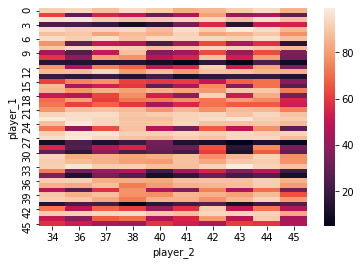

In [775]:
sns.heatmap(df_pivot)

In [779]:
def victim_name(idx):
    if isinstance(idx, str): return idx
    if idx == df_pivot.columns[-1]:
        return "v_normal"
    return "v%02d" % idx

def adv_name(idx):
    if isinstance(idx, str): return idx
    if idx == df_pivot.index[-1]:
        return "a_normal"
    return "a%02d" % idx

In [785]:
assert df_pivot.index.name == "player_1" # adversary
df_pivot.index = [adv_name(x) for x in df_pivot.index]

In [788]:
assert df_pivot.columns.name == "player_2" # victim
df_pivot.columns = [victim_name(x) for x in df_pivot.columns]

In [793]:
df_pivot.to_csv('pairs_win_rate_player_1.csv', index=True)